In [11]:
import os
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.decomposition import PCA

In [2]:
os.chdir('../')

In [3]:
data = pd.read_csv('data/processed/clf/data.csv')

In [4]:
X, y = data.drop('Estado al egreso', axis=1), data['Estado al egreso']

In [5]:
clf = RandomForestClassifier()

In [6]:
params = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],  
    'random_state': [1]
}

### Tunning RandomForestClassifier Model

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
4320 fits failed out of a total of 12960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4320 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  Fi

Best score:  0.9439791993352366
Best params:  {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 1}


/var/folders/z2/x55d_0sd3zl143hy_l05bnpr0000gn/T/ipykernel_33023/378811496.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=X.columns, palette='viridis')


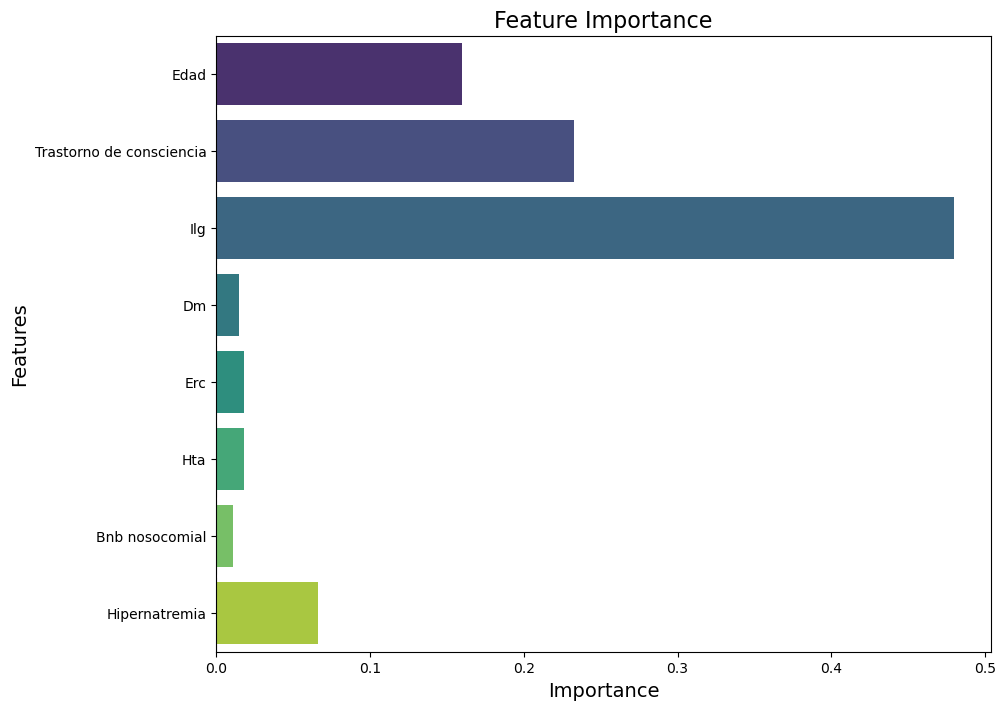

In [7]:
with mlflow.start_run():
    
    grid = GridSearchCV(estimator=clf, param_grid=params, scoring='f1', cv=5)
    grid.fit(X, y)

    mlflow.log_param('model_type', 'classification')
    for param, value in grid.best_params_.items():
        mlflow.log_param(param, value)
    
    mlflow.log_metric("best_score", grid.best_score_)
    mlflow.sklearn.log_model(grid.best_estimator_, 'RandomForestClassifier')

    print('Best score: ', grid.best_score_)
    print('Best params: ', grid.best_params_)

    feature_importance = grid.best_estimator_.feature_importances_

    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importance, y=X.columns, palette='viridis') 
    plt.title('Feature Importance', fontsize=16)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.axvline(0, color='grey', linestyle='--')

    mlflow.log_figure(plt.gcf(), 'feature_importance.png')
    plt.show()

In [79]:
with open('models/clf/model.pkl', 'wb') as file:
    pkl.dump(model, file)